In [1]:
import sys
import os
import struct
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

fpX = np.float32

import torch 
sys.path.append('/user_data/mmhender/imStat/code/')
root = os.path.dirname(os.path.dirname(os.getcwd()))
from plotting import plot_utils, summary_plots, load_fits, plot_prf_params
plot_utils.set_plotting_defaults()
from utils import roi_utils, nsd_utils, default_paths, stats_utils

In [2]:
best_layer_fn = '/user_data/mmhender/imStat/model_fits/S01/alexnet_all_conv_pca/Nov-23-2021_2247_09/all_fit_params'
out_tmp = torch.load(best_layer_fn)
out_tmp.keys()
best_layer = np.argmax(out_tmp['val_r2'][:,[1,3,5,7,9]], axis=1)

In [3]:
# Load results of the fitting procedure

subject = 1
volume_space=True
# semantic_discrim_type = 'indoor_outdoor'
semantic_discrim_type = 'all_supcat'

out_list = []
for ll in range(5):

#     fitting_type = 'alexnet_Conv%d_pca_plus_semantic_animacy'%(ll+1)
    fitting_type = 'alexnet_Conv%d_pca_plus_semantic_%s'%(ll+1, semantic_discrim_type)

    root = os.path.dirname(os.path.dirname(os.getcwd()))
    out, fig_save_folder = load_fits.load_fit_results(subject, volume_space, fitting_type, n_from_end=0, root=root, verbose=True);
#     load_fits.print_output_summary(out)
    out_list.append(out)

out = None
if not os.path.exists(fig_save_folder):
    os.makedirs(fig_save_folder)

loading from /user_data/mmhender/imStat/model_fits/S01/alexnet_Conv1_pca_plus_semantic_all_supcat/Nov-29-2021_2316_29/all_fit_params

dict_keys(['subject', 'volume_space', 'fitting_type', 'fitting_type2', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'which_prf_grid', 'models', 'best_losses', 'best_lambdas', 'best_params', 'lambdas', 'val_cc', 'val_r2', 'partial_masks', 'partial_version_names', 'zscore_features', 'zscore_in_groups', 'ridge', 'debug', 'up_to_sess', 'single_sess', 'shuff_rnd_seed', 'use_precomputed_prfs', 'saved_prfs_fn', 'corr_each_feature', 'discrim_each_axis', 'semantic_discrim_type', 'alexnet_layer_name', 'alexnet_padding_mode', 'use_pca_alexnet_feats', 'min_pct_var', 'max_pc_to_retain'])
loading from /user_data/mmhender/imStat/model_fits/S01/alexnet_Conv2_pca_plus_semantic_all_supcat/Nov-30-2021_0002_10/all_fit_params

dict_keys(['subject', 'volume_space', 'fitting_type', 'fitting_type2', 'voxel_mask', 'brain_nii_shape', 

In [19]:
np.sum(out_list[0]['best_params'][1][:,:,2]!=0, axis=1)

array([2, 2, 2, ..., 2, 2, 2])

In [4]:
# roi_def = roi_utils.get_combined_rois(subject,include_all=False,include_body=False,volume_space=True,verbose=False) 
roi_def = roi_utils.get_combined_rois(subject,include_all=True,include_body=True,volume_space=True,verbose=False) 

skip_inds = [10,11,15,23]
retlabs, facelabs, placelabs, bodylabs, \
        ret_names, face_names, place_names, body_names = roi_def


In [5]:
out_list[0]['partial_version_names']

['full_combined_model', 'just_alexnet', 'just_indoor_outdoor']

In [7]:
out_tmp['partial_version_names']

['full_combined_model',
 'just_Conv1_ReLU',
 'leave_out_Conv1_ReLU',
 'just_Conv2_ReLU',
 'leave_out_Conv2_ReLU',
 'just_Conv3_ReLU',
 'leave_out_Conv3_ReLU',
 'just_Conv4_ReLU',
 'leave_out_Conv4_ReLU',
 'just_Conv5_ReLU',
 'leave_out_Conv5_ReLU']

1066
2803
4882
5044
5943


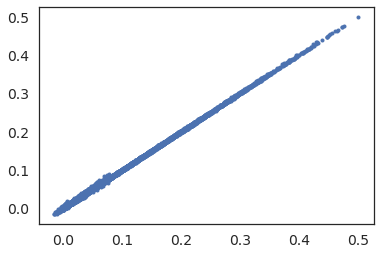

In [5]:
# Verifying that fits for best individual layer are almost identical across fitting procedures
# (only diff is which random set is held out as validation)
val_r2_bestalone = np.zeros_like(out_list[0]['val_r2'][:,0:1])
val_r2_bestalone2 = np.zeros_like(out_list[0]['val_r2'][:,0:1])
llinds = np.array([1,3,5,7,9])

for ll in range(5):
    inds = best_layer==ll
    print(np.sum(inds))
    val_r2_bestalone[inds,0] = out_list[ll]['val_r2'][inds,1]
    val_r2_bestalone2[inds,0] = out_tmp['val_r2'][inds,llinds[ll]]

plt.figure();
plt.plot(val_r2_bestalone[:,0], val_r2_bestalone2[:,0],'.')

In [6]:
from utils import stats_utils
from plotting import plot_prf_params

port=53333

best_ecc_deg, best_angle_deg, best_size_deg = plot_prf_params.get_prf_pars_deg(out_tmp, screen_eccen_deg=8.4)

names = ['pRF eccentricity', 'pRF angle', \
         'pRF size']
maps = [best_ecc_deg, best_angle_deg, best_size_deg]
cmaps = ['PRGn', 'Retinotopy_RYBCR', 'PRGn']
mins = [0,0,0]
maxes = [7, 360, 8.4]

# for each voxel, choosing which fits to use based on its best layer
val_r2 = np.zeros_like(out_list[0]['val_r2'])
for ll in range(5):
    inds = best_layer==ll
    print(np.sum(inds))
    val_r2[inds,:] = out_list[ll]['val_r2'][inds,:]


names += ['best AlexNet layer (individual R2)', 'R2 best single layer alexnet fit']
maps += [(best_layer+1).astype(np.float32),np.sqrt(val_r2[:,1])]
cmaps += ['plasma_r', 'PuBu']
mins += [0, 0]
maxes += [5, 0.8]

# variance partition
pp0 = 0
pp1 = 1
pp2 = 2
shared_ab, unique_a, unique_b = stats_utils.get_shared_unique_var(val_r2[:,pp0], val_r2[:,pp1], val_r2[:,pp2])
var_expl = np.concatenate((val_r2[:,pp0:pp0+1], unique_a[:,np.newaxis], unique_b[:,np.newaxis],shared_ab[:,np.newaxis]),axis=1)
# var_expl[bad_voxels,:] = np.nan

max_ind = (np.argmax(var_expl[:,1:3], axis=1)+2).astype(np.float32)
max_ind[max_ind==2] = 1.5

# max_ind[bad_voxels] = np.nan

maps += [copy.deepcopy(np.sqrt(var_expl[:,ii])) for ii in range(4)] + [copy.deepcopy(max_ind)]

names  += ['Concat model','Unique var: alexnet', 'Unique var: %s'%semantic_discrim_type, 'Shared variance', \
          'Unique var greater for alexnet or %s'%semantic_discrim_type]
cmaps += ['PuBu', 'PuBu', 'PuBu', 'PuBu', 'plasma_r']
mins += [0, 0, 0, 0, 0]
maxes += [0.8, 0.8, 0.8, 0.8, 3]


maps += [copy.deepcopy(np.sqrt(val_r2[:,ii])) for ii in list([1,2])]

names  += ['R2: alexnet', 'R2: %s'%semantic_discrim_type]
cmaps += ['PuBu', 'PuBu']
mins += [0, 0]
maxes += [0.8, 0.8]

vox2plot = val_r2[:,0]>=0

plot_utils.plot_maps_pycortex(maps, names, subject, out_tmp, roi_def=roi_def, vox2plot=vox2plot, \
                              fitting_type='alexnet + %s'%semantic_discrim_type, \
                              port=port, cmaps=cmaps, mins=mins, maxes=maxes)


1066
2803
4882
5044
5943
Data is in 3d volume space
navigate browser to: 127.0.0.1:53333


/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in sqrt
/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in sqrt
/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in sqrt


Started server on port 53333
Stopping server


In [22]:
np.array(out['partial_version_names'])[[5,4,1]]

array(['pyramid_texture_just_higher-level_plus_other_modules',
       'pyramid_texture_just_lower-level_plus_other_modules',
       'just_pyramid_texture'], dtype='<U52')

In [6]:
np.array(out['partial_version_names'])[[0,1,6]]

array(['full_combined_model', 'just_pyramid_texture',
       'just_sketch_tokens'], dtype='<U52')

1066
2803
4882
5044
5943


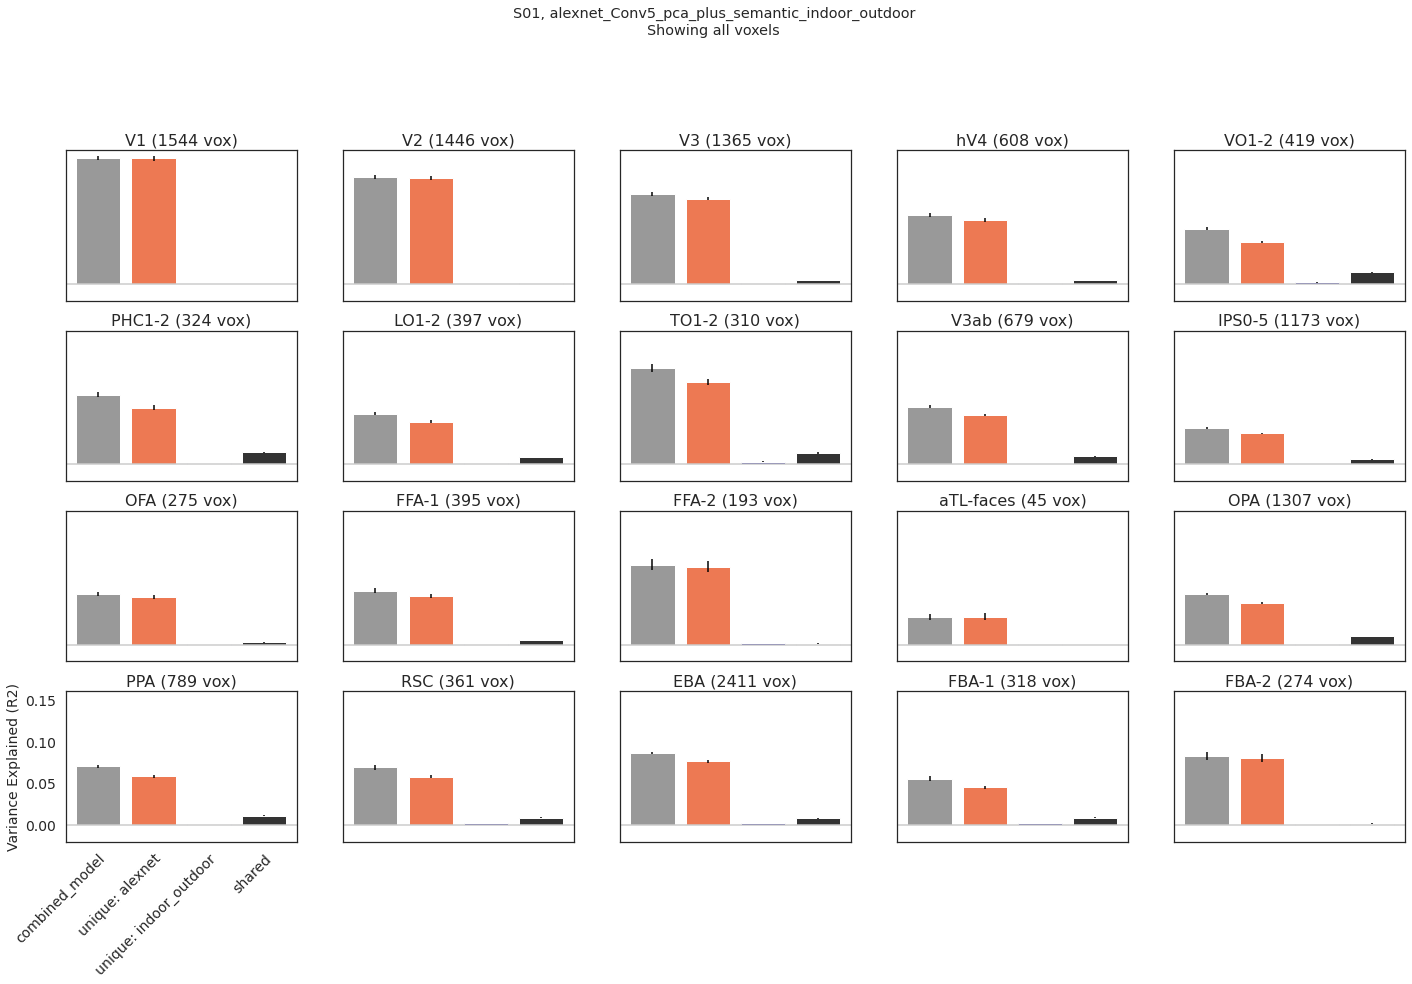

In [21]:
pp0 = 0
pp1 = 1
pp2 = 2

# for each voxel, choosing which fits to use based on its best layer
val_r2 = np.zeros_like(out_list[0]['val_r2'])
for ll in range(5):
    inds = best_layer==ll
    print(np.sum(inds))
    val_r2[inds,:] = out_list[ll]['val_r2'][inds,:]


name1 = out_list[0]['partial_version_names'][pp1][5:]
name2 = out_list[0]['partial_version_names'][pp2][5:]

ve_names = ['combined_model', 'unique: ' + name1, 'unique: ' + name2, 'shared']
shared_ab, unique_a, unique_b = stats_utils.get_shared_unique_var(val_r2[:,pp0], val_r2[:,pp1], val_r2[:,pp2])

var_expl = np.concatenate((val_r2[:,pp0:pp0+1], unique_a[:,np.newaxis], unique_b[:,np.newaxis],shared_ab[:,np.newaxis]),axis=1)

colors = cm.plasma(np.linspace(0,1,4))
colors = np.flipud(colors)
colors = np.concatenate((np.array([[0.6, 0.6, 0.6, 1]]), colors[[1,3],:], np.array([[0.2, 0.2, 0.2, 1]])), axis=0)

inds2use = val_r2[:,0]>0.01

bp = plot_utils.bar_plot(colors=colors, column_labels=ve_names, ylabel='Variance Explained (R2)', \
                                                        horizontal_line_pos=0, ylims=[-0.02, 0.16])
plot_utils.create_roi_subplots(var_expl, inds2use, bp, subject, out, roi_def=roi_def, skip_inds=skip_inds,\
                    suptitle='S%02d, %s\nShowing all voxels'%(subject, fitting_type))

plt.gcf().subplots_adjust(bottom=0.4)

if fig_save_folder is not None:
    plt.savefig(os.path.join(fig_save_folder,'Varpart_alexnet_semantic_bars_eachroi.pdf'))
    plt.savefig(os.path.join(fig_save_folder,'Varpart_alexnet_semantic_bars_eachroi.png'))

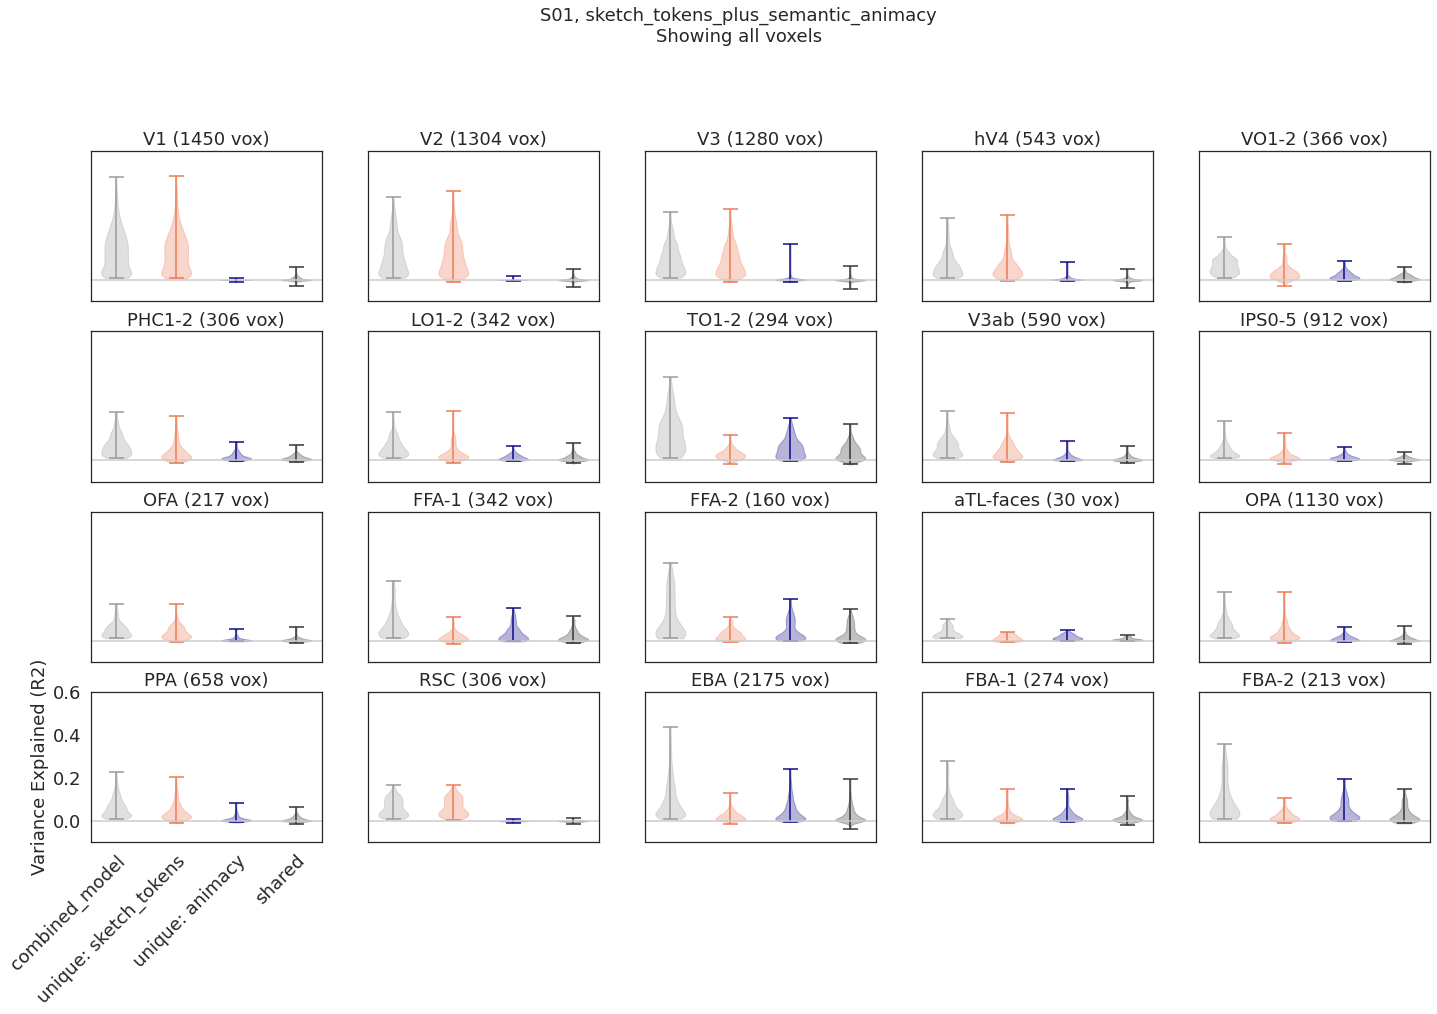

In [9]:
pp0 = 0
pp1 = 1
pp2 = 2

name1 = out['partial_version_names'][pp1][5:]
name2 = out['partial_version_names'][pp2][5:]
# val_r2 = stats_utils.get_r2(out)
val_r2 = out['val_r2']
ve_names = ['combined_model', 'unique: ' + name1, 'unique: ' + name2, 'shared']
shared_ab, unique_a, unique_b = stats_utils.get_shared_unique_var(val_r2[:,pp0], val_r2[:,pp1], val_r2[:,pp2])

var_expl = np.concatenate((val_r2[:,pp0:pp0+1], unique_a[:,np.newaxis], unique_b[:,np.newaxis],shared_ab[:,np.newaxis]),axis=1)

colors = cm.plasma(np.linspace(0,1,4))
colors = np.flipud(colors)
colors = np.concatenate((np.array([[0.6, 0.6, 0.6, 1]]), colors[[1,3],:], np.array([[0.2, 0.2, 0.2, 1]])), axis=0)

inds2use = val_r2[:,0]>0.01

vp = plot_utils.violin_plot(colors=colors, column_labels=ve_names, ylabel='Variance Explained (R2)', \
                                                        horizontal_line_pos=0, ylims=[-0.10, 0.60])
plot_utils.create_roi_subplots(var_expl, inds2use, vp, subject, out, roi_def=roi_def, skip_inds=skip_inds,\
                    suptitle='S%02d, %s\nShowing all voxels'%(subject, fitting_type))

plt.gcf().subplots_adjust(bottom=0.4)

if fig_save_folder is not None:
    plt.savefig(os.path.join(fig_save_folder,'Varpart_texture_ST_violin_eachroi.pdf'))
    plt.savefig(os.path.join(fig_save_folder,'Varpart_texture_ST_violin_eachroi.png'))